## DEEP LEARNING - IMAGE CAPTIONING

Image Captioning is the process of generating textual description of an image. 
It uses both **Natural Language Processing** and **Computer Vision** to generate the captions. 

The dataset will be in the form **[image → captions]**. 
The dataset consists of input images and their corresponding output captions.

* Read the pickle file (https://drive.google.com/file/d/1pcFPrRGGk0kEzLXlfIDrAvRZbTBiVeET/view?usp=sharing) and
    convert the data into the correct format which could be used for ML model.
* Pickle file contains the image id and the text associated with the image.

    **Eg:** '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .
    
    Each image can have multiple captions.
        319847657_2c40e14113.jpg --> image name
        #0 --> Caption ID
        \t --> separator between Image name and Image Caption
        A girl in a purple shirt hold a pillow . --> Image Caption
    
    Corresponding image wrt image name can be found in the image dataset folder.

**Image dataset Folder** : https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing

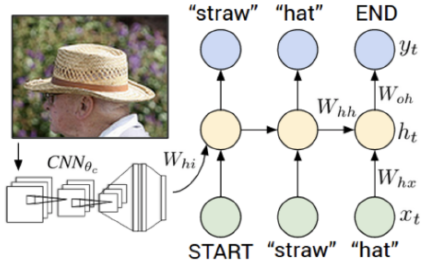


**Encoder**
The Convolutional Neural Network (CNN) can be thought of as an encoder. The input image is given to CNN to extract
the features. The last hidden state of the CNN is connected to the Decoder.

**Decoder**
The Decoder is a Recurrent Neural Network (RNN) which does language modelling up to the word level. The first time
step receives the encoded output from the encoder and also the [START] vector.

#### Points to be considered:

1. Import Libraries/Dataset
    * Import the required libraries
    * Check the GPU available (recommended- use free GPU provided by Google Colab).
    
2. Data Visualization and augmentation
    * Plot at least two samples and their captions (use matplotlib/seaborn/any other library).
    * Bring the train and test data in the required format.
    
3. Model Building
    * Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.
    * Create 3 layered RNN layer model and other relevant layers for image caption generation.
    * Add L2 regularization to all the RNN layers.
    * Add one layer of dropout at the appropriate position and give reasons.
    * Choose the appropriate activation function for all the layers.
    * Print the model summary.

4. Model Compilation
    * Compile the model with the appropriate loss function.
    * Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

5. Model Training
    * Train the model for an appropriate number of epochs. 
    * Print the train and validation loss for each epoch. 
    * Use the appropriate batch size.
    * Plot the loss and accuracy history graphs for both train and validation set. 
    * Print the total time taken for training.

6. Model Evaluation
    * Take a random image from google and generate caption for that image.
    

### Import Libraries/Dataset

!pip install tensorflow-gpu==2.3.0 keras==2.4 autocorrect nltk pandas progressbar2 symspellpy

In [1]:
import sys
import warnings 
import string
import os
import glob
from pathlib import Path
from PIL import Image
from time import time
import numpy as np
import pandas as pd 
import random
from numpy import array
from collections import Counter 

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
## Run ONLY ONCE
# nltk.download('punkt')

In [ ]:
import tensorflow as tf
import keras
# from keras.backend.tensorflow_backend import set_session
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional, GRU, SimpleRNN
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add

from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
warnings.filterwarnings("ignore")

os.getcwd()

In [3]:
tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None)

# tf.config.list_physical_devices()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

### ONLY RUN ONCE (AT FIRST RUN)
#### dataset is created as a dictionary and as a dataframe, you can load it from the saved csv (if not running for first time)

In [ ]:
csv = 'image_caption_data.csv'

pkl_object = pd.read_pickle(r'set_0.pkl')
print(len(pkl_object))

data_df = pd.DataFrame(columns = ['image_name','caption_id','caption_text'])
for i, obj in enumerate(pkl_object):
    data_dict = dict()
    split1 = obj.split('#')
#     print(f"Image name : {split1[0]}")
    data_dict['image_name'] = split1[0]
    split2 = split1[1].split('\t')
#     print(f"Caption ID : {split2[0]}")
    data_dict['caption_id'] = split2[0]
#     print(f"Caption : {split2[1]}")
    # Clean the caption of full-stops and extra-spaces
    cleaned_caption = text_clean(split2[1])
    data_dict['caption_text'] = cleaned_caption
    data_df = data_df.append(data_dict, ignore_index=True)
    
# Drop NaN captions
data_df = data_df.dropna().reset_index(drop=True)
print(len(data_df))

# save the processed data once and avoid running everytime
data_df.to_csv(csv, encoding='utf-8', index=False)
print(f"Processed data written to {csv}")

### LOAD DATA here
#### Load the saved processed data from csv and avoid running everytime

In [5]:
data_df = pd.read_csv('image_caption_data.csv')
data_df = data_df.dropna().reset_index(drop=True)
data_df['index'] = data_df.index
data = data_df.to_dict('records')

print(len(data))
print(len(data_df))

24997
24997


#### Find images and their corresponding text

In [13]:
images_path = Path('./Flicker8k_Dataset')

In [12]:
def find_texts(data, ith):
    for idx in data:
        if idx['image_name'] == data[ith]['image_name'] and idx['index'] != ith:
            print(f"caption_id: {idx['caption_id']};  text: {idx['caption_text']}")

{'image_name': '318667317_108c402140.jpg', 'caption_id': 4, 'caption_text': ' man in black hoodie be hold paper sign', 'index': 0}

index: 0,  image_name: 318667317_108c402140.jpg, 
caption_id: 4;  text:  man in black hoodie be hold paper sign
caption_id: 1;  text:  homeless man carry sign that say hungry
caption_id: 0;  text:  bearded man hold sign
caption_id: 3;  text:  man in black hoodie hold small sign


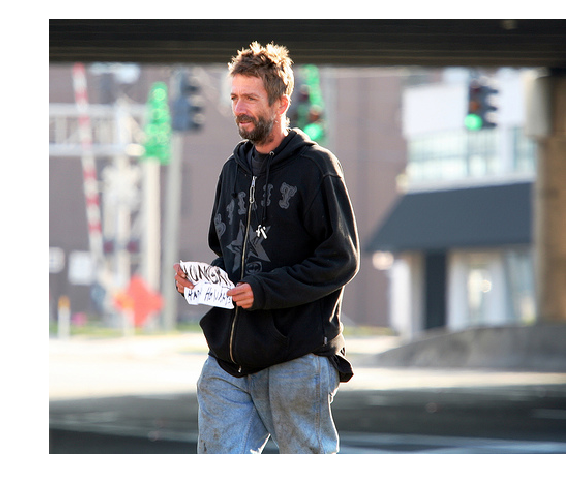

In [9]:
ith = 0

print(data[ith])
print()

print(f"index: {data[ith]['index']},  image_name: {data[ith]['image_name']}, \ncaption_id: {data[ith]['caption_id']};  text: {data[ith]['caption_text']}")
find_texts(data, ith)
img = plt.imread(str(images_path.joinpath(data[ith]['image_name'])))
plt.axis('off')
plt.imshow(img)
plt.show()

## Data Visualization and augmentation

In [ ]:
no_of_pictures_to_print = 5

for i in range(0,no_of_pictures_to_print):
    n = random.randint(0,len(data))
    img = plt.imread(str(images_path.joinpath(data[n]['image_name'])))
    plt.axis('off')
    plt.imshow(img)
    plt.text(1, 1, data[n]['caption_text'], weight="bold", style='normal', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    print(f"{i}; index: {data[n]['index']},  image_name: {data[n]['image_name']}")
    print(f"caption_id: {data[n]['caption_id']};  text: {data[n]['caption_text']}")
    find_texts(data, n)
    plt.show()

## Encoder : VGG16 Pre-trained model

In [6]:
def load_vgg_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


model_vg = VGG16(weights='imagenet', include_top=True)
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
no_of_pictures_to_print = 4

random_index = []
for i in range(0, no_of_pictures_to_print):
    n = random.randint(0, len(data))
    random_index.append(n)
    img = plt.imread(str(images_path.joinpath(data[n]['image_name'])))
    plt.axis('off')
    plt.imshow(img)
    plt.text(1, 1, data[n]['caption_text'], weight="bold", style='normal', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    print(f"{i}; index: {data[n]['index']},  image_name: {data[n]['image_name']}")
    print(f"caption_id: {data[n]['caption_id']};  text: {data[n]['caption_text']}")
    find_texts(data, n)
    plt.show()
    y_preds = model_vg.predict(load_vgg_image(str(images_path.joinpath(data[n]['image_name']))))
    print("PREDICTIONS from VGG-16 Model : {id, class, probability}")
    print(tf.keras.applications.vgg16.decode_predictions(y_preds, top=10))
    print("--------------------------------------------------------------------------------------------------------")
    print()

### Pop (delete) the last prediction layer from VGG16 model for our Encoder

In [21]:
# model_vg.layers.pop()

model_vgg = Model(inputs=model_vg.input, outputs=model_vg.layers[-2].output)

## display the deep learning model
model_vgg.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

## Decoder: RNN with Glove Embeddings

!wget https://nlp.stanford.edu/data/glove.42B.300d.zip

In [61]:
data_df

,image_name,caption_id,caption_text,index
0,318667317_108c402140.jpg,4,man in black hoodie be hold paper sign,0
1,2072574835_febf0c5fb9.jpg,4,Three race dog be run out of the start gate o...,1
2,3083016677_5782bc337c.jpg,4,Two motorcycle with two rider each,2
3,95734038_2ab5783da7.jpg,0,man on bike nest to river,3
4,241346146_f27759296d.jpg,1,football player try tackle another player who...,4
...,...,...,...,...
24992,2993388841_6746140656.jpg,3,basketball player in blue uniform be guard pl...,24992
24993,3578372039_57473f473c.jpg,1,young man ride skateboard and carry large bag,24993
24994,3186073578_6e115f45f5.jpg,0,man display photograph,24994
24995,2653552905_4301449235.jpg,3,Two man stand in front of condominium buildin...,24995


In [62]:
from copy import copy
import pkg_resources
from symspellpy.symspellpy import SymSpell


#Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
#term_index is the column of the term and count_index is the
#column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def spelling_corrector(input_term):
    ## sentence without any spaces
#     input_term = ' blackandwhite dog bound off the ground all feet in the air of yellow field'
    if input_term is not None:
        result = sym_spell.word_segmentation(input_term)
#     print(f"{result.corrected_string}, \n{result.distance_sum}, {result.log_prob_sum}")
        return str(result.corrected_string).strip()
    else:
        return "None"


def add_start_end_seq_tokens(captions):
    caps = []
    for txt in captions:
        if txt:
#             txt = f'startseq {spelling_corrector(txt)} endseq'
            txt = f'startseq {txt} endseq'
        else:
            print(txt)
            txt = 'NA'
        caps.append(txt.lower())
    return caps


# Add startseq & endseq to the captions
data_copy = copy(data_df)
data_copy["caption"] = add_start_end_seq_tokens(data_df['caption_text'].values)

print(len(data_copy))

24997


In [ ]:
data_0 = data_copy.drop_duplicates(["image_name"]).reset_index(drop=True)
data_0

#### Loading the image paths into memory

In [64]:
jpgs = os.listdir(images_path)
print(f"No. of images (.jpg flies) in given dataset:  {len(jpgs)}")
print()
print(f"No. of images with cleaned captions : {len(data_0.image_name)}")

No. of images (.jpg flies) in given dataset:  8091

No. of images with cleaned captions : 8037


### Loading image vectors into memory

In [67]:
from collections import OrderedDict
from progressbar import ProgressBar

fnames = []
dimages = []
dcaptions = []

vgg_image_size = 224
target_size = (vgg_image_size, vgg_image_size, 3)

with ProgressBar(max_value=len(data_0)) as bar:
    for i, data_row in data_0.iterrows():
        try:
            fname = data_row.image_name
            # load an image from file
            filename = images_path.joinpath(fname)
            image = load_img(filename, target_size=target_size)
            # convert the image pixels to a numpy array
            image = img_to_array(image)
            nimage = preprocess_input(image)
            y_pred = model_vgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
            dimages.append(y_pred.flatten())
            fnames.append(fname)
            dcaptions.append(data_row.caption)
            bar.update(i)
        except Exception as exp:
            print(exp)
            continue
    #print(i, filename)

 62% (5010 of 8037) |############        | Elapsed Time: 0:03:09 ETA:   0:01:51

[Errno 2] No such file or directory: 'Flicker8k_Dataset/2258277193_586949ec62.jpg.1'


100% (8037 of 8037) |####################| Elapsed Time: 0:05:03 Time:  0:05:03


In [65]:
fnames = np.array(fnames)
dcaptions = np.array(dcaptions)
dimages = np.array(dimages)


dimages.shape, dcaptions.shape, fnames.shape

((8036, 4096), (8036,), (8036,))

In [66]:
vocabulary = set()

for text in dcaptions:
    for word in word_tokenize(text):
        vocabulary.add(word)
        

print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 3409


### Tokenizing the vocabulary using NLTK Tokenizer

In [23]:
vocab_size = len(vocabulary) + 2

tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(dcaptions)
dtexts = tokenizer.texts_to_sequences(dcaptions)

In [ ]:
vocab_size = len(tokenizer.word_index.items()) + 1
print(vocab_size)
print()
tokenizer.word_index.items() 

In [ ]:
dtexts

### Split the data into train / validate / test

In [26]:
prop_test, prop_val = 0.05, 0.25

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts, Ntest, Nval):
    return(dtexts[:Ntest], dtexts[Ntest:Ntest+Nval], dtexts[Ntest+Nval:])



dt_test,  dt_val,  dt_train  = split_test_val_train(dtexts, Ntest, Nval)
di_test,  di_val,  di_train  = split_test_val_train(dimages, Ntest, Nval)
fnm_test, fnm_val, fnm_train = split_test_val_train(fnames, Ntest, Nval)

In [27]:
maxlen = np.max([len(text) for text in dtexts])

maxlen

31

In [28]:
def preprocessing(dtexts, dimages, data_type):
    N = len(dtexts)
    print(f"# {data_type} - captions/images = {N}")
    
    assert(N==len(dimages))
    Xtext, Ximage, ytext = [], [], []
    for text, image in zip(dtexts, dimages):

        for i in range(1, len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text], maxlen=maxlen, padding='post', truncating='post').flatten()
            out_text = to_categorical(out_text, num_classes=vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(f" {Xtext.shape} , {Ximage.shape} , {ytext.shape}")
    print()
    return Xtext, Ximage, ytext


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train, di_train, "train")
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val, di_val, "validate")

# pre-processing is not necessary for testing data
Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test, di_test, "test")

# train - captions/images = 5626
 (57196, 31) , (57196, 4096) , (57196, 3411)

# validate - captions/images = 2009
 (20484, 31) , (20484, 4096) , (20484, 3411)

# test - captions/images = 401
 (4038, 31) , (4038, 4096) , (4038, 3411)



### Loading the glove embedding

In [34]:
embeddings_index = {} 
f = open(Path('glove.6B.200d.txt'), encoding="utf-8")  #  glove.42B.300d.txt

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [35]:
len(embeddings_index)

400000

In [ ]:
# vocab_size = len(tokenizer.word_index)
print(vocab_size)



embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

missing = []
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missing.append({i: word})
            
print(f"No. of missing keywords : {len(missing)}")
missing

In [37]:
embedding_matrix.shape

(3411, 200)

## Model Building

input1 - Adding image features, not adding Dropout here since we avoid losing any important image features.

input2 - Adding textual features, using 3 layered RNNs with Bidirectional LSTMs and including Dropouts & Regularization.
         Reguralization and dropouts help tackling overfitting in our model.

Adding input1 & input2, we try to summarize the image features and generate the image captions.

#### Model Compilation
Learning Rate - 1e-4 : A large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train.

In [115]:
from tensorflow.keras import regularizers

neurons = 256
print(f"Vocabulary Size : {vocab_size}")
print(f"Embedding Dimension : {embedding_matrix.shape[1]}")
print(f"Maximum Caption Length : {maxlen}")
print()

inputs1 = Input(shape=(Ximage_train.shape[1],))
img_fe = Dense(neurons, activation='relu', name="ImageFeature")(inputs1)

inputs2 = Input(shape=(maxlen,))
# se1 = Embedding(vocab_size, 64, mask_zero=True)(inputs2)
se1 = Embedding(vocab_size, embedding_matrix.shape[1],
                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                trainable=False,
                mask_zero=True)(inputs2)
se2 = Bidirectional(LSTM(neurons, return_sequences=True))(se1)
se2 = Dropout(0.2)(se2)
se3 = LSTM(neurons, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(se2)
txt_fe = Dense(neurons, name="CaptionFeature", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(se3)
# ftxt, state = GRU(256, return_sequences=True,
#                   return_state=True, recurrent_initializer='glorot_uniform')(se1)
# txt_fe = SimpleRNN(neurons, name="CaptionFeature")(ftxt)
# txt_fe = Dropout(0.2)(txt_fe)

decoder1 = add([txt_fe, img_fe])
decoder2 = Dense(neurons, activation='relu')(decoder1)
# decoder2 = Dropout(0.2)(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model0 = Model(inputs=[inputs1, inputs2], outputs=outputs)

model0.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4))

model0.summary()

Vocabulary Size : 3411
Embedding Dimension : 200
Maximum Caption Length : 31

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 31, 200)      682200      input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 31, 512)      935936      embedding_8[0][0]                
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 31, 512)      0           bidirectional_10[0][0]           
________

In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 8
model_path = 'training_8'


start = time.time()
checkpoint_path = f"{model_path}/image_captions.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
callbacks = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,
                            monitor='val_loss',
                            verbose=1)

hist = model0.fit([Ximage_train, Xtext_train], ytext_train,
                  epochs=epochs, verbose=1, batch_size=batch_size,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),
                  callbacks = [callbacks])

end = time.time()
print()
print("TOTAL TIME TAKEN {:3.2f} Minutes".format((end - start )/60))

# model.save(f'{model_path}/saved_model')

In [ ]:
print(Ximage_train.shape, Xtext_train.shape, ytext_train.shape)


for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen, padding='post', truncating='post')
        yhat = model0.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 7
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic], di_test[:npic]):
    ## images 
    print(jpgfnm)
    filename = images_path.joinpath(jpgfnm) 
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1

plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, captions, bleus = [], [], [], []
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 300 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]   ## remove startseq, and endseq
    
    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu, jpgfnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu, jpgfnm, caption_true, caption))
    else:
        captions.append((bleu, jpgfnm, caption_true, caption))
        
        
print(f"Good captions    : {len(pred_good)} / {len(bleus)}  i.e. {round((len(pred_good)/len(bleus))*100,2)}%")
print(f"Bad captions     : {len(pred_bad)} / {len(bleus)}  i.e. {round((len(pred_bad)/len(bleus))*100,2)}%")
print(f"Average captions : {len(captions)} / {len(bleus)}  i.e. {round((len(captions)/len(bleus))*100,2)}%")

In [ ]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu, jpgfnm, caption_true, caption = pb
        ## images 
        filename = images_path.joinpath(jpgfnm)
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7, f"true: {caption_true}", weight="bold", fontsize=20, bbox=dict(fill=False, edgecolor='red', linewidth=2))
        ax.text(0,0.4, f"pred: {caption}", weight="bold", fontsize=20, bbox=dict(fill=False, edgecolor='green', linewidth=2))
        ax.text(0,0.1, f"BLEU: {bleu}", weight="bold", fontsize=15)
        count += 1
    plt.show()

    
print("Bad Captions")
print("------------------------------------------------------------------------------------------------")
plot_images(pred_bad)
print()
print("Good Captions")
print("------------------------------------------------------------------------------------------------")
plot_images(pred_good)

## Random Image - Caption Generation

In [97]:
def predict_image_captions(input_image):
    npix = 224
    target_size = (npix, npix, 3)

    # plt.figure(figsize=(8,8))
    ## images 
    print(f"Loading input : {input_image}")
    image_load = load_img(str(input_image), target_size=target_size)
    plt.imshow(image_load)

    image = img_to_array(image_load)
    nimage = preprocess_input(image)
    y_pred = model_vgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    img_features = y_pred.flatten()
    ## captions
    caption = predict_caption(img_features.reshape(1, 4096))
    caption = caption.split()
    caption = caption[1:-1]   ## remove startseq, and endseq
    caption = " ".join(caption)
    plt.axis('off')
    plt.text(1, -1, caption, weight="bold", style='normal', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    plt.show()

Loading input : dog.jpg


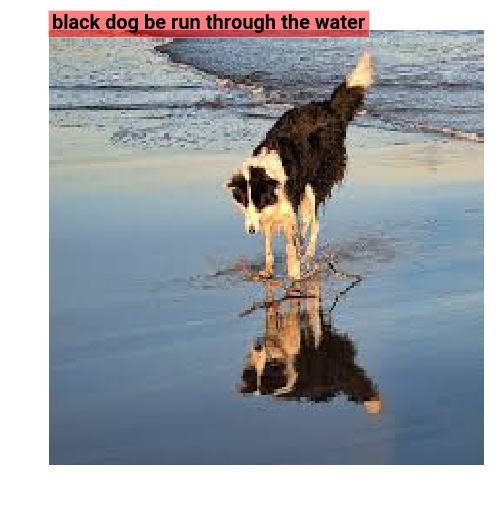

In [98]:
input_image = Path('dog.jpg')
predict_image_captions(input_image)

In [ ]:
input_image = Path('kids.jpg')
predict_image_captions(input_image)

In [ ]:
input_image = Path('surf.jpg')
predict_image_captions(input_image)

Loading input : vacation.jpg


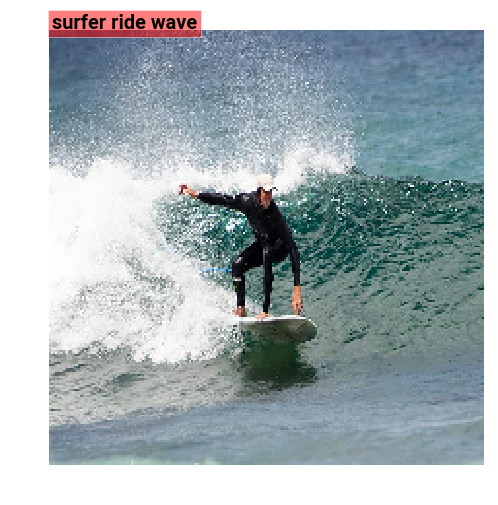

In [123]:
input_image = Path('vacation.jpg')
predict_image_captions(input_image)

### Model did not predict as expected, work in progress...

### References: 

https://www.tensorflow.org/tutorials/text/image_captioning